# `spcm` example for acquisition with Jupyter
_Spectrum Instrumentation GmbH (c)_

**1_jup_acq_single.py**

Shows a simple Standard acquisition (recording) mode example using only the few necessary commands
* connect a function generator that generates a sine wave with 10-100 kHz frequency and 200 mV amplitude to channel 0

Example for analog recording cards (digitizers) for the the M2p, M4i, M4x and M5i card-families.

_See the README file in the parent folder of this examples directory for information about how to use this example._

_See the LICENSE file for the conditions under which this software may be used and distributed._

## Import libraries
`spcm` the main library for communicating with the card. `units` sub-module from the `spcm` package for unit support. `numpy` for analysing the acquired data. `matplotlib` for plotting the acquired data.

In [19]:
import spcm
from spcm import units # spcm uses the pint library for unit handling (units is a UnitRegistry object)

import numpy as np
import matplotlib.pyplot as plt

## Open the card and setup the acquisition

* if you want to open a specific card using the device identifier

In [20]:
# card = spcm.Card('/dev/spcm0', verbose=True).open()

* if you want to open a remote card with ip-address

In [21]:
# card = spcm.Card('TCPIP::192.168.1.10::inst0::INSTR', verbose=True).open()

* if you want to open a card by its serial number

In [22]:
# card = spcm.Card(serial_number=12345, verbose=True).open()

* if you want to open the first card of a specific type

In [25]:
card = spcm.Card(card_type=spcm.SPCM_TYPE_AI, verbose=True).open()

Python version: 3.11.9 on Windows
Driver version: 7.7.23410
Kernel version: 0.0.0
Found '/dev/spcm1': M4i.4450-x8 sn 100001


### Setup the card to do data acquisition

For the acquisition, we set the operation mode of the card to `SPC_REC_STD_SINGLE`. For more information about this mode we refer to the specific manual of your device. The card timeout is set 5 s, this means that if it takes longer than 5 seconds to acquire the data after the card was started there will be an interrupt and the `spcm` package will throw an `spcm.SpcmTimeout` exception.

In [26]:
card.card_mode(spcm.SPC_REC_STD_SINGLE)
timeout = card.timeout(5 * units.s)

### Setup trigger

We'll be using a channel trigger and this means that both the `OR`- and `AND`-trigger masks (see your device manual) will be set to `SPC_TMASK_NONE`.

In [27]:
trigger = spcm.Trigger(card)
trigger.or_mask(spcm.SPC_TMASK_NONE)       # trigger set to none #software
trigger.and_mask(spcm.SPC_TMASK_NONE);      # no AND mask

### Setup the clock

The clock is set to using the internal oscillator with PLL to generate the required `20 MHz` sampling rate.

In [28]:
clock = spcm.Clock(card)
clock.mode(spcm.SPC_CM_INTPLL)            # clock mode internal PLL
sample_rate = clock.sample_rate(20 * units.MHz, return_unit=units.MHz)
print(f'Used sample rate: {sample_rate:.2f}')

Used sample rate: 15.62 megahertz


### Setup the input channels

Set up the usage of one channel (Channel 0) in the range of +/- 200 mV and with an offset of 0 V. Electrical termination of the channel is set to 50 Ohm.

In [29]:
channel0, = spcm.Channels(card, card_enable=spcm.CHANNEL0)
channel0.amp(200 * units.mV);
channel0.offset(0 * units.mV);
channel0.termination(1);

### Setup the channel triggering

Setup channel triggering for channel 0 and look for a positive slope crossing the 0 volt level.

In [30]:
trigger.ch_or_mask0(channel0.ch_mask())
trigger.ch_mode(channel0, spcm.SPC_TM_POS)
trigger.ch_level0(channel0, 0 * units.mV, return_unit=units.mV);

### Define the buffer for data transfer from the card to the PC and start the transfer

Setup a buffer in RAM to save 100 microseconds of data, of which 20 microseconds are from before the trigger and 80 microsecond are from after the trigger. At 20 MS/s sampling rate this corresponds to 20000 samples. The DMA transfer is started.

In [31]:
data_transfer = spcm.DataTransfer(card)
data_transfer.duration(100*units.us, post_trigger_duration=80*units.us)
data_transfer.start_buffer_transfer(spcm.M2CMD_DATA_STARTDMA)

Starting the DMA transfer and waiting until data is in board memory
... data transfer started


## Start the card

The card is started and the trigger engine is enabled. This command is waiting until all the data is acquired and transfer via DMA to the PC.

In [36]:
card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_DATA_WAITDMA)
print("Finished acquiring...")

Finished acquiring...


## Plot the data

Get the horizontal time data. Create a figure in Matplotlib. Convert the acquired data to electrical voltages. Print minimal and maximal data points. Plot the data with the trigger position at 0 and a line marking that position.

Channel 0
	Minimum: -0.175 V
	Maximum: 0.175 V


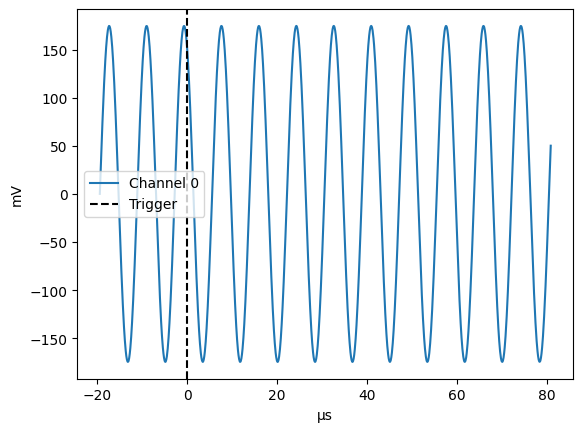

In [37]:
time_data_s = data_transfer.time_data()
fig, ax = plt.subplots()
unit_data_V = channel0.convert_data(data_transfer.buffer[channel0, :], units.V)
print(channel0)
print("\tMinimum: {:.3~P}".format(np.min(unit_data_V)))
print("\tMaximum: {:.3~P}".format(np.max(unit_data_V)))
ax.plot(time_data_s, unit_data_V, label=f"{channel0}")
ax.yaxis.set_units(units.mV)
ax.xaxis.set_units(units.us)
ax.axvline(0, color='k', linestyle='--', label='Trigger')
ax.legend()
plt.show()

## Stop the card and close the connection

IMPORTANT: at the end of usage the card needs to be manually closed.

In [24]:
card.close()
del card